In [2]:
# this notebook will read the results to show

In [3]:
%load_ext autoreload

In [4]:
%autoreload
import numpy as np
import pandas as pd
import sys
import os
import glob
import imageio
import time
import shutil
import matplotlib.pyplot as plt

from scipy import ndimage, signal
from cv2 import medianBlur, cvtColor, COLOR_RGB2GRAY

sys.path.append("..")

from PIL import Image
from costum_arild.source.utils import image_processing_utils, gdal_utils
from costum_arild.source.data_processing import TrainingImage

2023-06-03 14:58:43.210325: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
# find overlapping images in Gaula

In [6]:
def get_all_names_type(path, filetype = 'tif'):
    """
    get all the name of files end with `filetype` from `path`
    """
    filetype_end = f'*.{filetype}'    
    paths = glob.glob(
        os.path.join(path, filetype_end))
    return [os.path.split(name)[-1] for name in paths]

In [7]:
g47_path = '/media/saeid/LaCie/Saeid/segmentation/dataset/neurips dataset/After_revision/ml_final_version/full_images/tif/gaula_1947/image'
g63_path = '/media/saeid/LaCie/Saeid/segmentation/dataset/neurips dataset/After_revision/ml_final_version/full_images/tif/gaula_1963/image'
g98_path = '/media/saeid/LaCie/Saeid/segmentation/dataset/neurips dataset/After_revision/ml_final_version/full_images/tif/gaula_1998/image'

g47_names = get_all_names_type(g47_path, 'tif')
g63_names = get_all_names_type(g63_path, 'tif')
g98_names = get_all_names_type(g98_path, 'tif')

In [9]:
for img63 in g63_names:
    if img63 in g98_names:
        if img63 in g47_names:
            print(img63)

33-2-462-212-32.tif


In [ ]:
img_arr_63 = image_processing_utils.read_png_file(g)

In [5]:
train_rate=0.8
val_rate=0.2


src_path = '/home/saeid/phd/segmentation/dataset/new_dataset/AAAI_ex2/devided/nea_orkla_g_512'
dst_path = '/home/saeid/phd/segmentation/dataset/new_dataset/AAAI_ex2/devided/512'

# dataset_split_train_vlidation_test_notebook(
#                                     src_path=src_path, dst_path=dst_path, 
#                                     train_rate=train_rate,
#                                     val_rate=val_rate)

# The historgram of different times

In [6]:
# get list out of one path
def count_class_list_label_2d(original_label_matrix, remove_unknown=False, verbose=0):
    """ returns list of vectors in which number of classes of one image is mentioned (2d)"""
    class_count_list = []
    start = time.time()
    
    if original_label_matrix.shape[-1] != 3:
        # it is not a 3 channel label so we can calculate the class info
        # get the information about the classes
        (unique_tmp, counts_tmp) = np.unique(
            original_label_matrix, return_counts=True)
        class_count_vec = np.zeros(6)
        class_count_vec[unique_tmp] = counts_tmp
        
        if remove_unknown:
            class_count_vec = class_count_vec[1:]
        
        class_count_list.append(class_count_vec)
    else:
        raise NotImplementedError('it is not 2d')

    end = time.time()
    if verbose == 1:
        print(f'the time takes {end - start}')
    return class_count_list

# list of valid colors

def class_count_list_dataframe(class_count_list, unknown_zero, remove_unknown=False):

    
    class_df = pd.DataFrame(class_count_list, dtype='float32')
    
    if not remove_unknown:
        class_df.loc['class_sum'] = class_df.sum(axis=0)

        if unknown_zero == True:
            class_df = class_df.rename(columns={5: "W", 1: "G", 2: "V", 3: "F", 4: "A", 0: "U"})
        else:
            class_df = class_df.rename(columns={0: "W", 1: "G", 2: "V", 3: "F", 4: "A", 5: "U"})
    else:
        
        if unknown_zero == True:
            class_df.loc['class_sum'] = class_df.sum(axis=0)
            class_df = class_df.rename(columns={4: "W", 0: "G", 1: "V", 2: "F", 3: "A"})
        else:
            class_df.loc['class_sum'] = class_df.sum(axis=0)
            class_df = class_df.rename(columns={0: "W", 1: "G", 2: "V", 3: "F", 4: "A"})
        

    class_df.loc['class_sum_percent'] = ((class_df.loc['class_sum'] / class_df.loc['class_sum'].sum()) * 100)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    return class_df

In [6]:
# img_name = '33-2-462-210-22median15.tif'
img_name = '33-2-463-211-01median15.tif'
g63_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/fpn_output/1963'
g98_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/fpn_output/1998'

# g63_img_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/1963-33-2-462-210-22.tif'
g63_img_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/1963_33-2-463-211-01.tif'

g63_path = os.path.join(g63_path, img_name)
# g63_img_path = os.path.join(g63_img_path, img_name)
g98_path = os.path.join(g98_path, img_name)

In [7]:
g63_lbl = gdal_utils.read_tiff_file(g63_path, numpy_array_only=True)
g63_img = gdal_utils.read_tiff_file(g63_img_path, numpy_array_only=True)
g98_lbl = gdal_utils.read_tiff_file(g98_path, numpy_array_only=True)

g63_lbl = np.squeeze(g63_lbl)
g98_lbl = np.squeeze(g98_lbl)

In [8]:
# make the unknown to be the same in both of the labels
unknown_class = 0
g63_lbl[g98_lbl == unknown_class] = unknown_class
g98_lbl[g63_lbl == unknown_class] = unknown_class
# same with the image

In [9]:
g63_lbl_clr = image_processing_utils.label_to_rgb(label_2d=g63_lbl, 
                                               unknown_zero_flag=True, 
                                               most_distant=False)

g98_lbl_clr = image_processing_utils.label_to_rgb(label_2d=g98_lbl, 
                                               unknown_zero_flag=True, 
                                               most_distant=False)

In [10]:
# dest_save = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2'
# image_processing_utils.save_to_png(g98_lbl_clr[:,500:3800,:], 
#                                    img_path=os.path.join(dest_save, '1998_label.png'))

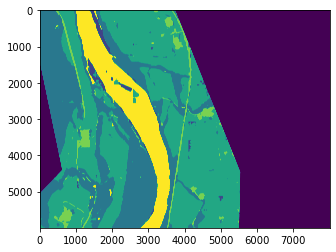

In [11]:
plt.imshow(g98_lbl)

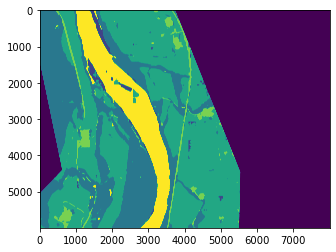

In [12]:
plt.imshow(g98_lbl)

In [13]:
g63_class_count_list = count_class_list_label_2d(g63_lbl,
                                                remove_unknown=True,)
print(g63_class_count_list)
g63_class_count_df = class_count_list_dataframe(class_count_list=g63_class_count_list, 
                                                unknown_zero=True,
                                                remove_unknown=True,)

g63_class_count_df = g63_class_count_df.loc['class_sum_percent'].to_frame()
g63_class_count_df = g63_class_count_df.rename(columns={"class_sum_percent": "Gaula_1963"})

[array([ 2952620.,  7721547., 14072511.,   940647.,  2353356.])]


In [14]:
g63_class_count_df

,Gaula_1963
G,10.53
V,27.54
F,50.19
A,3.35
W,8.39


In [15]:
g98_class_count_list = count_class_list_label_2d(g98_lbl,
                                                remove_unknown=True,)
print(g63_class_count_list)
g98_class_count_df = class_count_list_dataframe(class_count_list=g98_class_count_list, 
                                                unknown_zero=True,
                                                remove_unknown=True,)

g98_class_count_df = g98_class_count_df.loc['class_sum_percent'].to_frame()
g98_class_count_df = g98_class_count_df.rename(columns={"class_sum_percent": "Gaula_1998"})

[array([ 2952620.,  7721547., 14072511.,   940647.,  2353356.])]


In [16]:
g98_class_count_df['Gaula_1998'].to_frame()

,Gaula_1998
G,1.47
V,30.78
F,50.88
A,4.15
W,12.72


/home/saeid/anaconda3/envs/arildenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


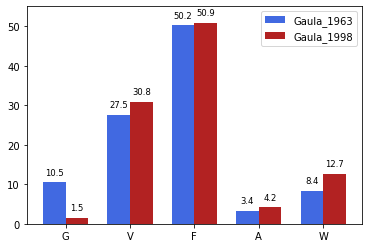

In [28]:
dest_save = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2'

new_dataset = g63_class_count_df
new_dataset['Gaula_1998'] = g98_class_count_df['Gaula_1998'].to_frame()

ax = new_dataset.plot.bar(color=['royalblue', 'firebrick'],
                            width=0.7, rot=0,
                            legend=True,)

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=1),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                fontsize=8.5,
                textcoords='offset points')
    
fig = ax.get_figure()
ax.set_ylim(0,55)
fig.savefig( os.path.join(dest_save, 'bar_plot.png'), dpi=1200)

In [124]:
# read the picture of Gaula 1963 and then project the 

img_matrix = gdal_utils.read_tiff_file(g63_img_path, numpy_array_only=True)
# image_processing_utils.read_png_file(img_path)

In [125]:
# make matrix to be RGB
# img_matrix = np.stack([img_matrix,img_matrix,img_matrix], 
#                       axis=-1)

In [126]:
img_matrix.shape

(6000, 8000, 3)

In [127]:
# get the gaula 1963 river with till color
g63_river = np.zeros_like(g63_lbl)

water_class = 5
g63_river[g63_lbl == water_class] = 1

darkblue_palette = np.array([[0, 0, 0], 
#                     [0, 128, 128],
#                              [0,10,200]
                             [25, 50, 225],
                            ],  
                   dtype=np.uint8)

g63_river = darkblue_palette[g63_river.astype(np.uint8)]

In [128]:
# get the gaula 1998 river with till color
g98_river = np.zeros_like(g98_lbl)

water_class = 5
g98_river[g98_lbl == water_class] = 1

teal_palette = np.array([[0, 0, 0], 
#                         [3, 37, 127],
                         [225, 34, 34]
                        ],  
                   dtype=np.uint8)

g98_river = teal_palette[g98_river.astype(np.uint8)]

In [129]:
g98_river.shape

(6000, 8000, 3)

In [130]:
color_layer = np.zeros_like(g98_river)

color_layer[g98_lbl == water_class] = g98_river[g98_lbl == water_class]
color_layer[g63_lbl == water_class] = g63_river[g63_lbl == water_class]
intersection_index = np.logical_and(g63_lbl == water_class, g98_lbl == water_class)
color_layer[intersection_index] = (0.5 * g63_river[intersection_index] + 0.5 * g98_river[intersection_index])

img_matrix[color_layer != 0] = (0.45*img_matrix[color_layer != 0] + 0.55*color_layer[color_layer != 0])

In [131]:
img_matrix[g63_lbl == unknown_class] = unknown_class

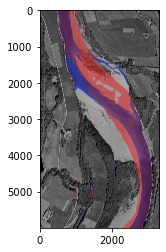

In [132]:
plt.imshow(img_matrix[:,500:3800,:])

In [133]:
image_processing_utils.save_to_png(img_matrix[:,500:3800,:], 
                                   img_path=os.path.join(dest_save, 'water.png'))

In [149]:
# # same thing for gravel
# # read the picture of Gaula 1963 and then project the 
# # rivers on it

# img_name = '33-2-462-209-12.png'
# g63_img_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/dataset_division/train_set/gaula_1963/png/image'
# img_path = os.path.join(g63_img_path, img_name)
# img_matrix = image_processing_utils.read_png_file(img_path)
# # make matrix to be RGB
# img_matrix = np.stack([img_matrix,img_matrix,img_matrix], 
#                       axis=-1)

img_matrix = gdal_utils.read_tiff_file(g63_img_path, numpy_array_only=True)

In [150]:
# get the gaula 1963 river with till color
g63_river = np.zeros_like(g63_lbl)

water_class = 1
g63_river[g63_lbl == water_class] = 1

darkblue_palette = np.array([[0, 0, 0], 
                    #[0, 128, 128],
                    [65, 105, 225]
                             ,],  
                   dtype=np.uint8)

g63_river = darkblue_palette[g63_river.astype(np.uint8)]

In [151]:
# get the gaula 1998 river with till color
g98_river = np.zeros_like(g98_lbl)

water_class = 1
g98_river[g98_lbl == water_class] = 1

teal_palette = np.array([[0, 0, 0], 
                        #[3, 37, 127],
                         [178, 34, 34]],  
                   dtype=np.uint8)
g98_river = teal_palette[g98_river.astype(np.uint8)]

In [152]:
color_layer = np.zeros_like(g98_river)

color_layer[g98_lbl == water_class] = g98_river[g98_lbl == water_class]
color_layer[g63_lbl == water_class] = g63_river[g63_lbl == water_class]
intersection_index = np.logical_and(g63_lbl == water_class, g98_lbl == water_class)
color_layer[intersection_index] = (0.5 * g63_river[intersection_index] + 0.5 * g98_river[intersection_index])

img_matrix[color_layer != 0] = (0.45*img_matrix[color_layer != 0] + 0.55*color_layer[color_layer != 0])

In [153]:
img_matrix[g63_lbl == unknown_class] = unknown_class

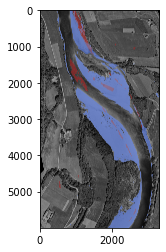

In [154]:
plt.imshow(img_matrix[:,500:3800,:])

In [155]:
image_processing_utils.save_to_png(img_matrix[:,500:3800,:], 
                                   img_path=os.path.join(dest_save, 'gravel.png'))

In [141]:
# saving images of new and old rivers

In [142]:
g63_img_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/1963_33-2-463-211-01.tif'
g98_img_path = '/home/saeid/phd/segmentation/dataset/neurips dataset/change_over_time/candidate_image2/1998_33-2-463-211-01.tif'


img_matrix = gdal_utils.read_tiff_file(g63_img_path, numpy_array_only=True)
img_matrix_98 = gdal_utils.read_tiff_file(g98_img_path, numpy_array_only=True)

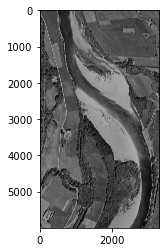

In [143]:
plt.imshow(img_matrix[:,500:3800,:])

In [146]:
image_processing_utils.save_to_png(img_matrix[:,500:3800,:], 
                                   img_path=os.path.join(dest_save, '1963.png'))

In [148]:
image_processing_utils.save_to_png(img_matrix_98[:,500:3800,:], 
                                   img_path=os.path.join(dest_save, '1998.png'))